# Rated DPG for Cartpole


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/aras/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
import numpy as np
rewards = [each[3] for each in batch]
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.0


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [7]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [8]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [9]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG: r+(gamma*nextQ)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True) # Qs
    rates = tf.reshape(rates, shape=[-1, 1])
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=rates)) # 0-1
    dlossA /= 2
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    dlossQ /= 2
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [10]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [11]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [12]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [14]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [15]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [16]:
goal = 500
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done), -1])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/goal
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        num_step = 0 # reset

In [17]:
idx = np.random.choice(np.arange(memory_size// batch_size))
batch = np.array(memory.buffer)[idx*batch_size:(idx+1)*batch_size]
rates = np.array([each[5] for each in batch])
batch = batch[rates >= (np.max(rates)*0.9)]
states = np.array([each[0] for each in batch])
actions = np.array([each[1] for each in batch])
next_states = np.array([each[2] for each in batch])
rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])
rates = np.array([each[5] for each in batch])

In [18]:
batch.shape, \
states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape

((92, 6), (92, 4), (92,), (92, 4), (92,), (92,), (92,))

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [19]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dlossA_list, dlossQ_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111):
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        total_reward = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), -1])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the last played episode
            if done is True:
                rate = total_reward/ goal # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                        memory.buffer[-1-idx][5] = rate # rate each SA pair
            
            # Training using a max rated batch
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                batch = np.array(memory.buffer)[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])
                if (np.max(rates)*0.9) > 0: # non-rated data -1
                    break
            batch = batch[rates >= (np.max(rates)*0.9)]
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rates = np.array([each[5] for each in batch])            
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dlossA, dlossQ, _, _, _ = sess.run([model.g_loss, model.d_lossA, model.d_lossQ, 
                                                       model.g_opt, model.d_optA, model.d_optQ],
                                                      feed_dict = {model.states: states, 
                                                                   model.actions: actions,
                                                                   model.targetQs: targetQs, 
                                                                   model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dlossA_list.append([ep, np.mean(dlossA_batch)])
        dlossQ_list.append([ep, np.mean(dlossQ_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= goal:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:24.0000 R:24.0000 rate:0.0480 gloss:0.6918 dlossA:0.8147 dlossQ:0.8218 exploreP:0.9976
Episode:1 meanR:18.5000 R:13.0000 rate:0.0260 gloss:0.6876 dlossA:0.8123 dlossQ:0.8223 exploreP:0.9963
Episode:2 meanR:16.0000 R:11.0000 rate:0.0220 gloss:0.7007 dlossA:0.8128 dlossQ:0.8237 exploreP:0.9953
Episode:3 meanR:15.7500 R:15.0000 rate:0.0300 gloss:0.6939 dlossA:0.8124 dlossQ:0.8239 exploreP:0.9938
Episode:4 meanR:15.8000 R:16.0000 rate:0.0320 gloss:0.7062 dlossA:0.8148 dlossQ:0.8287 exploreP:0.9922
Episode:5 meanR:15.6667 R:15.0000 rate:0.0300 gloss:0.6957 dlossA:0.8108 dlossQ:0.8282 exploreP:0.9907
Episode:6 meanR:17.1429 R:26.0000 rate:0.0520 gloss:0.7091 dlossA:0.8165 dlossQ:0.8347 exploreP:0.9882
Episode:7 meanR:16.7500 R:14.0000 rate:0.0280 gloss:0.7199 dlossA:0.8208 dlossQ:0.8304 exploreP:0.9868
Episode:8 meanR:17.0000 R:19.0000 rate:0.0380 gloss:0.7171 dlossA:0.8175 dlossQ:0.8367 exploreP:0.9850
Episode:9 meanR:17.3000 R:20.0000 rate:0.0400 gloss:0.7152 dlossA:0.8103 

Episode:79 meanR:22.1375 R:18.0000 rate:0.0360 gloss:0.7964 dlossA:0.8405 dlossQ:0.9196 exploreP:0.8393
Episode:80 meanR:22.1358 R:22.0000 rate:0.0440 gloss:0.7985 dlossA:0.8378 dlossQ:0.9271 exploreP:0.8375
Episode:81 meanR:22.1707 R:25.0000 rate:0.0500 gloss:0.7883 dlossA:0.8435 dlossQ:0.8819 exploreP:0.8354
Episode:82 meanR:22.3133 R:34.0000 rate:0.0680 gloss:0.7972 dlossA:0.8462 dlossQ:0.9052 exploreP:0.8326
Episode:83 meanR:22.4524 R:34.0000 rate:0.0680 gloss:0.7941 dlossA:0.8441 dlossQ:0.9048 exploreP:0.8298
Episode:84 meanR:22.9765 R:67.0000 rate:0.1340 gloss:0.7986 dlossA:0.8421 dlossQ:0.9115 exploreP:0.8244
Episode:85 meanR:23.1628 R:39.0000 rate:0.0780 gloss:0.7936 dlossA:0.8389 dlossQ:0.9158 exploreP:0.8212
Episode:86 meanR:23.1494 R:22.0000 rate:0.0440 gloss:0.8032 dlossA:0.8459 dlossQ:0.9066 exploreP:0.8194
Episode:87 meanR:23.1477 R:23.0000 rate:0.0460 gloss:0.7952 dlossA:0.8400 dlossQ:0.9180 exploreP:0.8175
Episode:88 meanR:23.3483 R:41.0000 rate:0.0820 gloss:0.7930 dlos

Episode:158 meanR:27.0900 R:37.0000 rate:0.0740 gloss:0.8042 dlossA:0.8458 dlossQ:0.9363 exploreP:0.6727
Episode:159 meanR:27.3200 R:42.0000 rate:0.0840 gloss:0.7958 dlossA:0.8446 dlossQ:0.9239 exploreP:0.6699
Episode:160 meanR:27.9700 R:96.0000 rate:0.1920 gloss:0.7988 dlossA:0.8394 dlossQ:0.9379 exploreP:0.6636
Episode:161 meanR:27.9800 R:12.0000 rate:0.0240 gloss:0.7945 dlossA:0.8357 dlossQ:0.9365 exploreP:0.6628
Episode:162 meanR:27.9300 R:19.0000 rate:0.0380 gloss:0.7874 dlossA:0.8253 dlossQ:0.9439 exploreP:0.6616
Episode:163 meanR:28.0800 R:30.0000 rate:0.0600 gloss:0.7910 dlossA:0.8428 dlossQ:0.9141 exploreP:0.6596
Episode:164 meanR:27.8500 R:18.0000 rate:0.0360 gloss:0.7793 dlossA:0.8416 dlossQ:0.9091 exploreP:0.6585
Episode:165 meanR:27.9300 R:22.0000 rate:0.0440 gloss:0.7884 dlossA:0.8439 dlossQ:0.9066 exploreP:0.6570
Episode:166 meanR:28.7000 R:90.0000 rate:0.1800 gloss:0.7950 dlossA:0.8400 dlossQ:0.9157 exploreP:0.6512
Episode:167 meanR:29.6300 R:113.0000 rate:0.2260 gloss:

Episode:236 meanR:56.0700 R:171.0000 rate:0.3420 gloss:0.8049 dlossA:0.8416 dlossQ:0.9441 exploreP:0.4103
Episode:237 meanR:56.6600 R:86.0000 rate:0.1720 gloss:0.8057 dlossA:0.8399 dlossQ:0.9287 exploreP:0.4068
Episode:238 meanR:57.7000 R:123.0000 rate:0.2460 gloss:0.7963 dlossA:0.8342 dlossQ:0.9359 exploreP:0.4020
Episode:239 meanR:58.3500 R:81.0000 rate:0.1620 gloss:0.8179 dlossA:0.8433 dlossQ:0.9471 exploreP:0.3988
Episode:240 meanR:59.4900 R:148.0000 rate:0.2960 gloss:0.8033 dlossA:0.8397 dlossQ:0.9342 exploreP:0.3931
Episode:241 meanR:60.0900 R:82.0000 rate:0.1640 gloss:0.8072 dlossA:0.8372 dlossQ:0.9470 exploreP:0.3900
Episode:242 meanR:61.2800 R:153.0000 rate:0.3060 gloss:0.8117 dlossA:0.8362 dlossQ:0.9485 exploreP:0.3842
Episode:243 meanR:62.1100 R:104.0000 rate:0.2080 gloss:0.8009 dlossA:0.8375 dlossQ:0.9205 exploreP:0.3803
Episode:244 meanR:62.5800 R:66.0000 rate:0.1320 gloss:0.7982 dlossA:0.8368 dlossQ:0.9285 exploreP:0.3779
Episode:245 meanR:63.7700 R:134.0000 rate:0.2680 g

Episode:313 meanR:269.6800 R:307.0000 rate:0.6140 gloss:2.1660 dlossA:1.8474 dlossQ:1.0781 exploreP:0.0426
Episode:314 meanR:273.9200 R:500.0000 rate:1.0000 gloss:2.2320 dlossA:1.8940 dlossQ:1.0881 exploreP:0.0410
Episode:315 meanR:277.5100 R:439.0000 rate:0.8780 gloss:2.2815 dlossA:1.9802 dlossQ:1.1118 exploreP:0.0397
Episode:316 meanR:280.4700 R:435.0000 rate:0.8700 gloss:2.2950 dlossA:1.9101 dlossQ:1.1148 exploreP:0.0384
Episode:317 meanR:285.3100 R:500.0000 rate:1.0000 gloss:2.3758 dlossA:2.0814 dlossQ:1.1402 exploreP:0.0370
Episode:318 meanR:288.5300 R:376.0000 rate:0.7520 gloss:2.4059 dlossA:2.0844 dlossQ:1.1110 exploreP:0.0360
Episode:319 meanR:292.5500 R:454.0000 rate:0.9080 gloss:2.4087 dlossA:2.0396 dlossQ:1.0747 exploreP:0.0349
Episode:320 meanR:296.8100 R:500.0000 rate:1.0000 gloss:2.4908 dlossA:2.1749 dlossQ:1.1349 exploreP:0.0337
Episode:321 meanR:300.9000 R:445.0000 rate:0.8900 gloss:2.5551 dlossA:2.2839 dlossQ:1.1434 exploreP:0.0326
Episode:322 meanR:304.9800 R:500.0000

Episode:390 meanR:479.6100 R:500.0000 rate:1.0000 gloss:10.9712 dlossA:7.3724 dlossQ:5.9958 exploreP:0.0108
Episode:391 meanR:479.6100 R:500.0000 rate:1.0000 gloss:11.1476 dlossA:7.0602 dlossQ:6.3019 exploreP:0.0107
Episode:392 meanR:482.4000 R:500.0000 rate:1.0000 gloss:11.2794 dlossA:7.6495 dlossQ:6.3674 exploreP:0.0107
Episode:393 meanR:482.4000 R:500.0000 rate:1.0000 gloss:11.1646 dlossA:7.1444 dlossQ:6.2138 exploreP:0.0107
Episode:394 meanR:482.4000 R:500.0000 rate:1.0000 gloss:11.5273 dlossA:7.5822 dlossQ:6.2722 exploreP:0.0106
Episode:395 meanR:482.4000 R:500.0000 rate:1.0000 gloss:11.8812 dlossA:7.9329 dlossQ:7.2163 exploreP:0.0106
Episode:396 meanR:481.0800 R:368.0000 rate:0.7360 gloss:11.8701 dlossA:8.1490 dlossQ:7.1873 exploreP:0.0106
Episode:397 meanR:482.2400 R:500.0000 rate:1.0000 gloss:11.7318 dlossA:7.1927 dlossQ:6.6994 exploreP:0.0106
Episode:398 meanR:482.2400 R:500.0000 rate:1.0000 gloss:11.9148 dlossA:7.0516 dlossQ:6.9687 exploreP:0.0105
Episode:399 meanR:482.2400 R

Episode:466 meanR:495.9000 R:500.0000 rate:1.0000 gloss:12.8966 dlossA:1.6538 dlossQ:18.6030 exploreP:0.0100
Episode:467 meanR:495.9000 R:500.0000 rate:1.0000 gloss:13.1633 dlossA:1.1739 dlossQ:18.4821 exploreP:0.0100
Episode:468 meanR:495.9000 R:500.0000 rate:1.0000 gloss:13.5419 dlossA:1.0809 dlossQ:20.9079 exploreP:0.0100
Episode:469 meanR:495.9000 R:500.0000 rate:1.0000 gloss:14.1367 dlossA:0.7915 dlossQ:21.2342 exploreP:0.0100
Episode:470 meanR:495.9000 R:500.0000 rate:1.0000 gloss:14.4994 dlossA:0.7421 dlossQ:21.8392 exploreP:0.0100
Episode:471 meanR:495.9000 R:500.0000 rate:1.0000 gloss:14.2920 dlossA:0.9754 dlossQ:21.7188 exploreP:0.0100
Episode:472 meanR:495.9000 R:500.0000 rate:1.0000 gloss:13.8289 dlossA:0.6224 dlossQ:21.6232 exploreP:0.0100
Episode:473 meanR:495.5800 R:468.0000 rate:0.9360 gloss:13.1203 dlossA:0.4730 dlossQ:19.0900 exploreP:0.0100
Episode:474 meanR:495.5800 R:500.0000 rate:1.0000 gloss:12.3819 dlossA:0.5355 dlossQ:17.9817 exploreP:0.0100
Episode:475 meanR:4

Episode:542 meanR:497.0100 R:500.0000 rate:1.0000 gloss:5.0905 dlossA:0.0599 dlossQ:9.1899 exploreP:0.0100
Episode:543 meanR:497.0100 R:500.0000 rate:1.0000 gloss:4.9998 dlossA:0.0715 dlossQ:8.3337 exploreP:0.0100
Episode:544 meanR:497.0100 R:500.0000 rate:1.0000 gloss:4.9518 dlossA:0.0604 dlossQ:8.6622 exploreP:0.0100
Episode:545 meanR:497.0100 R:500.0000 rate:1.0000 gloss:5.1528 dlossA:0.0645 dlossQ:9.4601 exploreP:0.0100
Episode:546 meanR:497.0100 R:500.0000 rate:1.0000 gloss:4.9596 dlossA:0.0519 dlossQ:8.8906 exploreP:0.0100
Episode:547 meanR:497.0100 R:500.0000 rate:1.0000 gloss:4.9506 dlossA:0.0782 dlossQ:8.8076 exploreP:0.0100
Episode:548 meanR:497.0100 R:500.0000 rate:1.0000 gloss:4.9114 dlossA:0.0458 dlossQ:9.0742 exploreP:0.0100
Episode:549 meanR:497.0100 R:500.0000 rate:1.0000 gloss:5.1609 dlossA:0.0607 dlossQ:9.4502 exploreP:0.0100
Episode:550 meanR:497.0100 R:500.0000 rate:1.0000 gloss:4.6140 dlossA:0.0617 dlossQ:8.5802 exploreP:0.0100
Episode:551 meanR:497.0100 R:500.0000

Episode:619 meanR:499.2400 R:500.0000 rate:1.0000 gloss:4.0894 dlossA:0.0661 dlossQ:10.7998 exploreP:0.0100
Episode:620 meanR:499.2400 R:500.0000 rate:1.0000 gloss:4.2190 dlossA:0.0865 dlossQ:10.9096 exploreP:0.0100
Episode:621 meanR:499.2400 R:500.0000 rate:1.0000 gloss:4.1527 dlossA:0.0701 dlossQ:11.0350 exploreP:0.0100
Episode:622 meanR:499.2400 R:500.0000 rate:1.0000 gloss:4.2130 dlossA:0.0508 dlossQ:11.2918 exploreP:0.0100
Episode:623 meanR:499.2400 R:500.0000 rate:1.0000 gloss:4.1671 dlossA:0.0601 dlossQ:11.0944 exploreP:0.0100
Episode:624 meanR:499.2400 R:500.0000 rate:1.0000 gloss:4.2266 dlossA:0.0359 dlossQ:11.4765 exploreP:0.0100
Episode:625 meanR:499.2400 R:500.0000 rate:1.0000 gloss:4.1309 dlossA:0.0814 dlossQ:10.9112 exploreP:0.0100
Episode:626 meanR:499.2400 R:500.0000 rate:1.0000 gloss:4.2578 dlossA:0.0587 dlossQ:11.3358 exploreP:0.0100
Episode:627 meanR:499.2400 R:500.0000 rate:1.0000 gloss:4.1898 dlossA:0.0734 dlossQ:11.0465 exploreP:0.0100
Episode:628 meanR:499.2400 R

Episode:695 meanR:499.6600 R:500.0000 rate:1.0000 gloss:3.7745 dlossA:0.0286 dlossQ:12.5777 exploreP:0.0100
Episode:696 meanR:499.6600 R:500.0000 rate:1.0000 gloss:3.5805 dlossA:0.0356 dlossQ:12.1473 exploreP:0.0100
Episode:697 meanR:499.6600 R:500.0000 rate:1.0000 gloss:3.8295 dlossA:0.0273 dlossQ:12.4984 exploreP:0.0100
Episode:698 meanR:499.6600 R:500.0000 rate:1.0000 gloss:3.7316 dlossA:0.0362 dlossQ:11.9266 exploreP:0.0100
Episode:699 meanR:499.6600 R:500.0000 rate:1.0000 gloss:3.7157 dlossA:0.0237 dlossQ:12.1974 exploreP:0.0100
Episode:700 meanR:499.6600 R:500.0000 rate:1.0000 gloss:3.5852 dlossA:0.0445 dlossQ:11.1264 exploreP:0.0100
Episode:701 meanR:499.6600 R:500.0000 rate:1.0000 gloss:3.6121 dlossA:0.0280 dlossQ:12.3119 exploreP:0.0100
Episode:702 meanR:499.6600 R:500.0000 rate:1.0000 gloss:3.7123 dlossA:0.0404 dlossQ:11.5727 exploreP:0.0100
Episode:703 meanR:499.6600 R:500.0000 rate:1.0000 gloss:3.6431 dlossA:0.0409 dlossQ:12.7774 exploreP:0.0100
Episode:704 meanR:499.6600 R

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

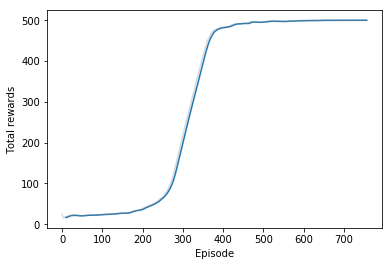

In [21]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

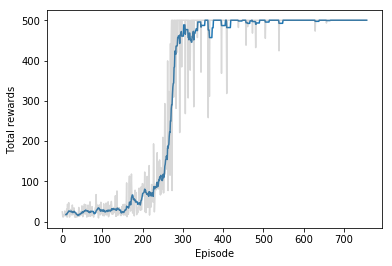

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [23]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

SyntaxError: invalid syntax (<ipython-input-23-a0b0af09d9f3>, line 6)

In [ ]:
eps, arr = np.array(dlossA_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

In [ ]:
eps, arr = np.array(dlossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.